In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from mqt.predictor import rl, ml
df = pd.read_csv(ml.helper.get_path_results(), sep=',')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 30

apply_normalization = False

/Users/nils/Desktop/mqt-predictor/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 2x2 Matrix With Mean Results and Optimization Criterion Comparison

In [2]:
tmp_df = df[df["MQTPredictor_expected_fidelity_expected_fidelity"]>=0]
tmp_df = tmp_df[tmp_df["MQTPredictor_critical_depth_expected_fidelity"]>=0]
MQT_expected_fidelity = [tmp_df["MQTPredictor_expected_fidelity_expected_fidelity"].mean(),  tmp_df["MQTPredictor_expected_fidelity_critical_depth"].mean()]
MQT_critical_depth = [tmp_df["MQTPredictor_critical_depth_expected_fidelity"].mean(), tmp_df["MQTPredictor_critical_depth_critical_depth"].mean()]

In [3]:
print(np.round(MQT_expected_fidelity,2))
print(np.round(MQT_critical_depth,2))

[0.67 0.42]
[0.12 0.55]


## Top 3 Bins

In [4]:
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

## Calcualte Data Points

In [5]:
def calculate_median(row, column_name):
    columns = [col for col in row.index if col.endswith(column_name) and not "MQT" in col]
    values = [value for col, value in row[columns].items() if value != -1]
    return np.median(values) if values else None

df['expected_expected_fidelity_median'] = df.apply(calculate_median, column_name="_expected_fidelity",axis=1)
df['critical_depth_median'] = df.apply(calculate_median, column_name="_critical_depth",axis=1)
df['expected_expected_fidelity_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
df['expected_expected_fidelity_max_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].max(), axis=1)
df['critical_depth_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_critical_depth') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
df['critical_depth_max_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_critical_depth') and 'MQT' not in col]].max(), axis=1)

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/1883737292.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['expected_expected_fidelity_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/1883737292.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['expected_expected_fidelity_min_other'] = df.apply(lambda row: row[[col fo

## Optionally: Normalize

In [6]:
if apply_normalization:
    divider_column_name = 'expected_expected_fidelity_max_other'
    
    # Get the list of column names ending with "_expected_fidelity"
    columns_to_divide = [col for col in df.columns if col.endswith("_expected_fidelity") or col in ['expected_expected_fidelity_min_other', 'exptected_expected_fidelity_max_other', 'exptected_expected_fidelity_median' ]]
    
    # Iterate through each column and perform the division
    for col_name in columns_to_divide:
        df[col_name] = df[col_name].divide(df[divider_column_name])
    
    divider_column_name = 'critical_depth_max_other'
    
    # Get the list of column names ending with "_expected_fidelity"
    columns_to_divide = [col for col in df.columns if col.endswith("_critical_depth") or col in ['critical_depth_min_other', 'critical_depth_max_other',  'critical_depth_median' ]]
    
    # Iterate through each column and perform the division
    for col_name in columns_to_divide:
        df[col_name] = df[col_name].divide(df[divider_column_name])

# Expected Fidelity

In [7]:
predictor = ml.Predictor()

training_data = predictor.get_prepared_training_data(figure_of_merit="expected_fidelity", save_non_zero_indices=True)
indices_test = training_data.indices_test
names_list = training_data.names_list

test_benchmarks_expected_fidelity = [names_list[index_test] for index_test in indices_test]
df_filtered_expected_fidelity = df[df["file_path"].isin(test_benchmarks_expected_fidelity)]
df_filtered_expected_fidelity = df_filtered_expected_fidelity[df_filtered_expected_fidelity["MQTPredictor_expected_fidelity_expected_fidelity"]>=0]

In [8]:
print("Fid Improvement: ", df_filtered_expected_fidelity.loc[df['MQTPredictor_expected_fidelity_expected_fidelity'] != np.inf, 'MQTPredictor_expected_fidelity_expected_fidelity'].max())

Fid Improvement:  0.9870717764


In [9]:
len(df_filtered_expected_fidelity)

178

In [10]:
df_filtered_expected_fidelity['MQTPredictor_expected_fidelity_expected_fidelity'].describe()

count    178.000000
mean       0.692942
std        0.308962
min        0.000000
25%        0.598688
50%        0.814883
75%        0.917971
max        0.987072
Name: MQTPredictor_expected_fidelity_expected_fidelity, dtype: float64

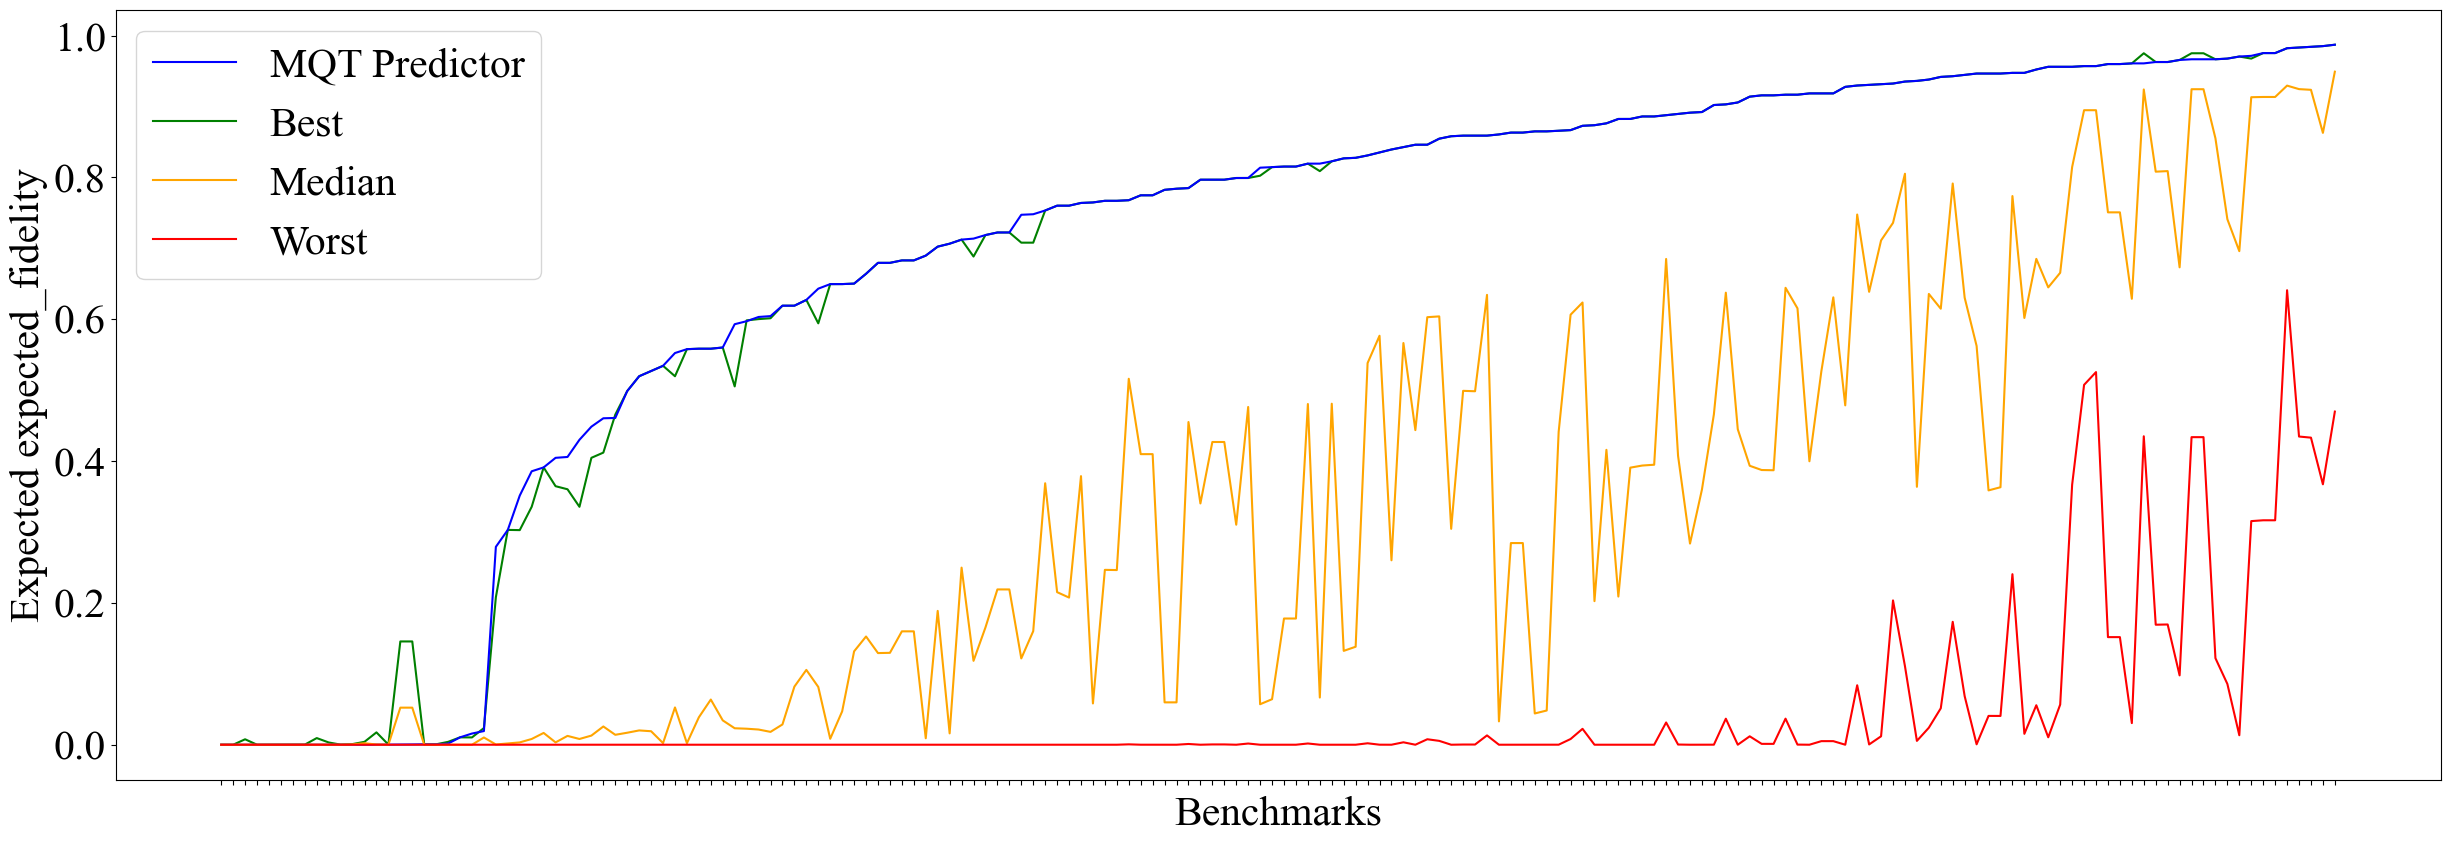

In [11]:
plot_kind = "line"
df_filtered_and_sorted_expected_fidelity = df_filtered_expected_fidelity.sort_values(by=['MQTPredictor_expected_fidelity_expected_fidelity'])
ax = df_filtered_and_sorted_expected_fidelity.plot(x="file_path", y="expected_expected_fidelity_max_other", label="Best", rot=90, kind=plot_kind, color="green", figsize=(30,10))
df_filtered_and_sorted_expected_fidelity.plot(x="file_path", y="MQTPredictor_expected_fidelity_expected_fidelity", label="MQT Predictor", kind=plot_kind, rot=90, ax=ax, color="blue")
df_filtered_and_sorted_expected_fidelity.plot(x="file_path", y="expected_expected_fidelity_median", kind=plot_kind, rot=90, ax=ax, color="orange", label="Median")
df_filtered_and_sorted_expected_fidelity.plot(x="file_path", y="expected_expected_fidelity_min_other", label="Worst", rot=90, kind=plot_kind, ax=ax, color="red")

if plot_kind == "line":
    plt.xticks(range(len(df_filtered_and_sorted_expected_fidelity.file_path)), df_filtered_and_sorted_expected_fidelity.file_path)

plt.xticks(
    list(range(0, len(df_filtered_and_sorted_expected_fidelity.file_path), 1)),
    [ "" for i in range(0, len(df_filtered_and_sorted_expected_fidelity.file_path), 1)],
    fontsize=16,
)

plt.xlabel("Benchmarks")
plt.ylabel("Expected expected_fidelity")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

plt.savefig("results/expected_fidelity_plot.pdf", bbox_inches='tight')

## Top 3 expected_fidelity

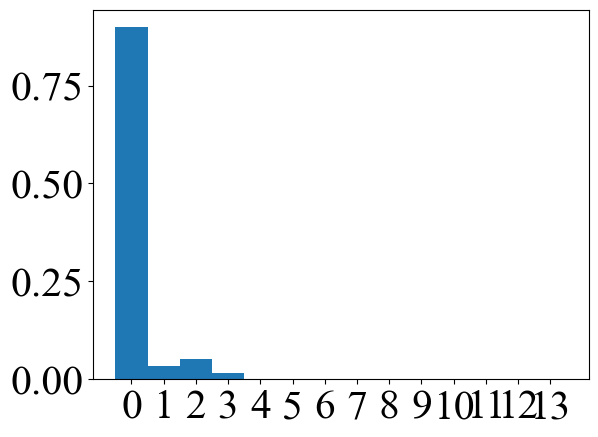

In [12]:
df_filtered_and_sorted_expected_fidelity['Rank_MQT_expected_fidelity'] = df_filtered_and_sorted_expected_fidelity.apply(lambda row: sum(1 for col in df_filtered_and_sorted_expected_fidelity.columns if col.endswith('_expected_fidelity') and not "MQT" in col and row['MQTPredictor_expected_fidelity_expected_fidelity'] >=row[col]), axis=1)
df_filtered_and_sorted_expected_fidelity['Rank_MQT_expected_fidelity'] = len([col for col in df_filtered_and_sorted_expected_fidelity.columns if col.endswith('_expected_fidelity') and not "MQT" in col]) - df_filtered_and_sorted_expected_fidelity.Rank_MQT_expected_fidelity
plt.hist(df_filtered_and_sorted_expected_fidelity.Rank_MQT_expected_fidelity.values, bins=range(0,15,1), align="left", weights=np.ones(len(df_filtered_and_sorted_expected_fidelity)) / len(df_filtered_and_sorted_expected_fidelity))
plt.xticks(range(0,14,1));

In [13]:
len(df_filtered_and_sorted_expected_fidelity[df_filtered_and_sorted_expected_fidelity['Rank_MQT_expected_fidelity']==0])

160

In [14]:
len(df_filtered_and_sorted_expected_fidelity)

178

In [15]:
count_top3 = 0
for index, row in df_filtered_and_sorted_expected_fidelity.iterrows():
    if row['Rank_MQT_expected_fidelity'] in [0, 1, 2]:
        count_top3 += 1
        
print("Percentage of Top-3:", count_top3/len(df_filtered_and_sorted_expected_fidelity))

Percentage of Top-3: 0.9831460674157303


# Critical Depth

In [16]:
predictor = ml.Predictor()
training_data = predictor.get_prepared_training_data(figure_of_merit="critical_depth", save_non_zero_indices=True)
indices_test = training_data.indices_test
names_list = training_data.names_list

test_benchmarks_critical_depth = [names_list[index_test] for index_test in indices_test]
df_filtered_critical_depth = df[df["file_path"].isin(test_benchmarks_critical_depth)]
df_filtered_critical_depth = df_filtered_critical_depth[df_filtered_critical_depth["MQTPredictor_critical_depth_critical_depth"]>=0]

In [17]:
print("Crit. Dep. Improvement: ", df_filtered_critical_depth.loc[df['MQTPredictor_critical_depth_critical_depth'] != np.inf, 'MQTPredictor_critical_depth_critical_depth'].max())

Crit. Dep. Improvement:  0.9103448276


In [18]:
len(df_filtered_critical_depth)

180

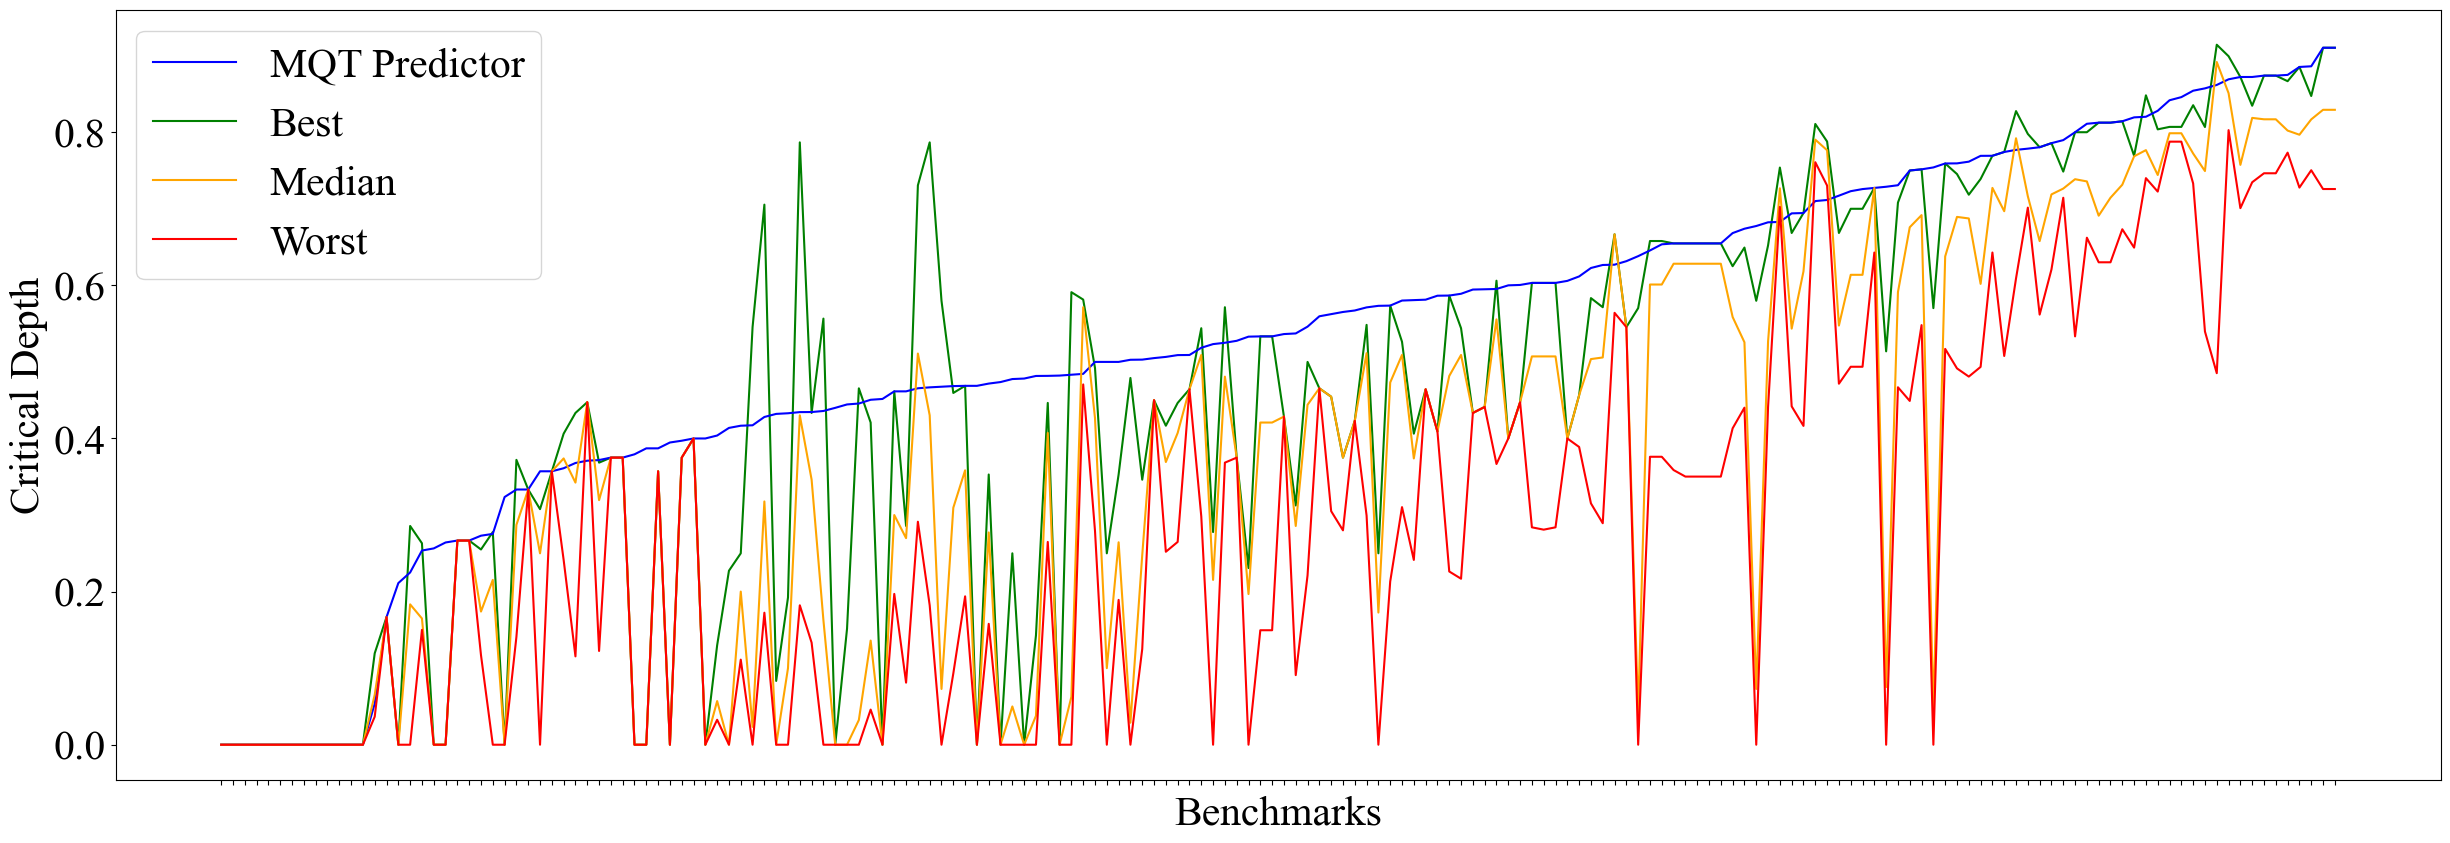

In [19]:
plot_kind = "line"
df_filtered_and_sorted_critical_depth = df_filtered_critical_depth.sort_values(by=['MQTPredictor_critical_depth_critical_depth'])
ax = df_filtered_and_sorted_critical_depth.plot(x="file_path", y="critical_depth_max_other", label="Best", rot=90, kind=plot_kind, color="green", figsize=(30,10))
df_filtered_and_sorted_critical_depth.plot(x="file_path", y="MQTPredictor_critical_depth_critical_depth", kind=plot_kind, rot=90, ax=ax, color="blue", label="MQT Predictor")
df_filtered_and_sorted_critical_depth.plot(x="file_path", y="critical_depth_median", kind=plot_kind, rot=90, ax=ax, color="orange", label="Median")
df_filtered_and_sorted_critical_depth.plot(x="file_path", y="critical_depth_min_other", label="Worst", rot=90, kind=plot_kind, ax=ax, color="red")


if plot_kind == "line":
    plt.xticks(range(len(df_filtered_and_sorted_critical_depth.file_path)), df_filtered_and_sorted_critical_depth.file_path);


plt.xticks(
    list(range(0, len(df_filtered_and_sorted_critical_depth.file_path), 1)),
    ["" for i in range(0, len(df_filtered_and_sorted_critical_depth), 1)],
    fontsize=18,
)

plt.xlabel("Benchmarks")
plt.ylabel("Critical Depth")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

plt.savefig("results/critical_depth_plot.pdf", bbox_inches='tight')

## Top 3 Critical Depth

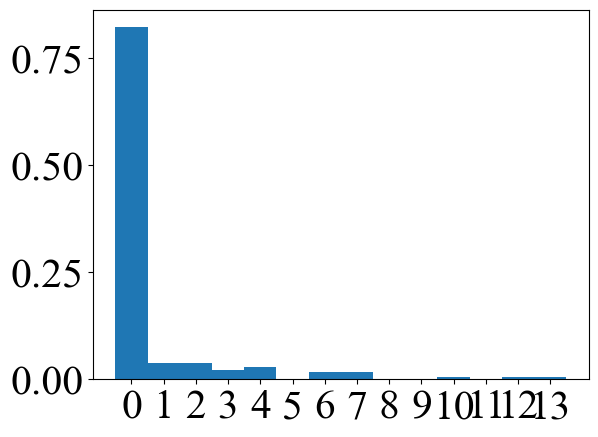

In [20]:
df_filtered_and_sorted_critical_depth['Rank_MQT_critical_depth'] = df_filtered_and_sorted_critical_depth.apply(lambda row: sum(1 for col in df_filtered_and_sorted_critical_depth.columns if col.endswith('_critical_depth') and not "MQT" in col and row['MQTPredictor_critical_depth_critical_depth'] >= row[col]), axis=1)
df_filtered_and_sorted_critical_depth['Rank_MQT_critical_depth'] = len([col for col in df_filtered_and_sorted_critical_depth.columns if col.endswith('_critical_depth') and not "MQT" in col]) - df_filtered_and_sorted_critical_depth.Rank_MQT_critical_depth
plt.hist(df_filtered_and_sorted_critical_depth.Rank_MQT_critical_depth.values, bins=range(0,15,1), align="left", weights=np.ones(len(df_filtered_and_sorted_critical_depth)) / len(df_filtered_and_sorted_critical_depth))
plt.xticks(range(0,14,1));

In [21]:
len(df_filtered_and_sorted_critical_depth[df_filtered_and_sorted_critical_depth['Rank_MQT_critical_depth']==0])

148

In [22]:
len(df_filtered_and_sorted_critical_depth)

180

In [23]:
count_top3 = 0
for index, row in df_filtered_and_sorted_critical_depth.iterrows():
    if row['Rank_MQT_critical_depth'] in [0, 1, 2]:
        count_top3 += 1

# Print the total count
print("Percentage of Top-3:", count_top3/len(df_filtered_and_sorted_critical_depth))

Percentage of Top-3: 0.9


# GHZ Evaluation

In [24]:
df = pd.read_csv(ml.helper.get_path_results(ghz_results=True), sep=',')
df = df[df.num_qubits<32]
plt.rcParams["font.size"] = 50

In [25]:
df['expected_fidelity_median'] = df.apply(calculate_median, column_name="_expected_fidelity",axis=1)
df['critical_depth_median'] = df.apply(calculate_median, column_name="_critical_depth",axis=1)
df['expected_fidelity_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
df['expected_fidelity_max_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].max(), axis=1)
df['critical_depth_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_critical_depth') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
df['critical_depth_max_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_critical_depth') and 'MQT' not in col]].max(), axis=1)

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/3859663328.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['expected_fidelity_min_other'] = df.apply(lambda row: row[[col for col in row.index if col.endswith('_expected_fidelity') and 'MQT' not in col]].replace(-1, np.nan).min(skipna=True), axis=1)
/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/3859663328.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['expected_fidelity_min_other'] = df.apply(lambda row: row[[col for col in row.index

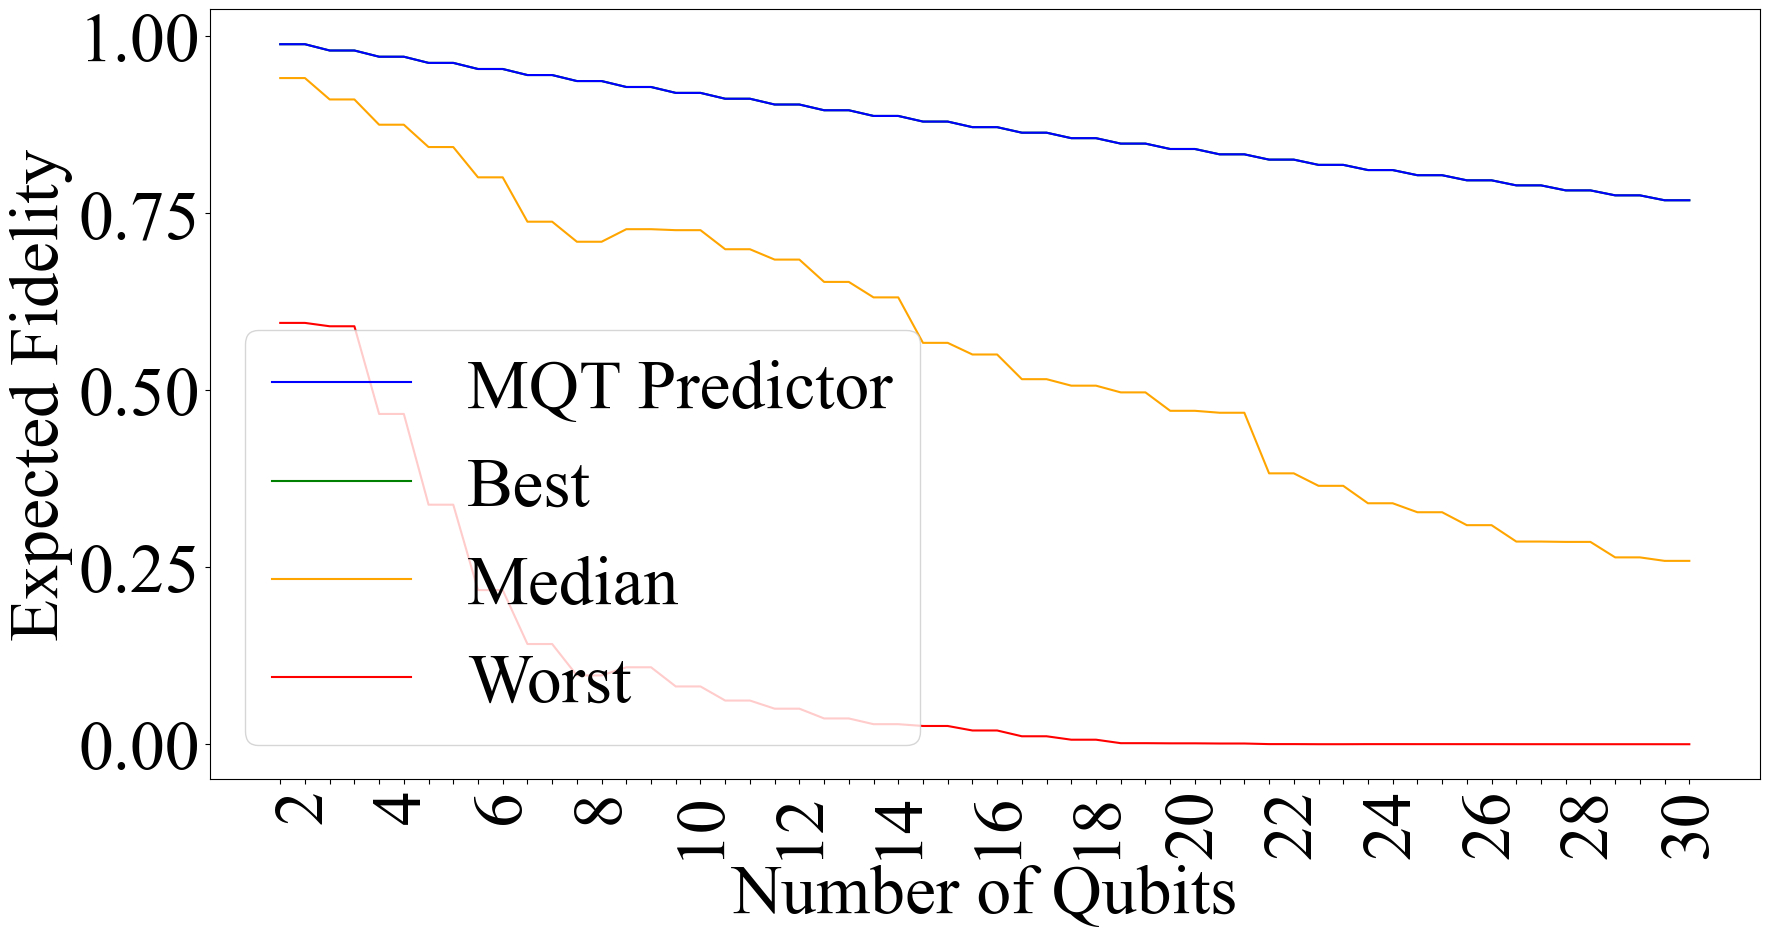

In [26]:
plot_kind = "line"
df = df.sort_values(by=['num_qubits'])
ax = df.plot(x="file_path", y="expected_fidelity_max_other", label="Best", rot=90, kind=plot_kind, color="green", figsize=(20,10))
df.plot(x="file_path", y="MQTPredictor_expected_fidelity_expected_fidelity", label="MQT Predictor", kind=plot_kind, rot=90, ax=ax, color="blue")
df.plot(x="file_path", y="expected_fidelity_median", kind=plot_kind, rot=90, ax=ax, color="orange", label="Median")
df.plot(x="file_path", y="expected_fidelity_min_other", label="Worst", rot=90, kind=plot_kind, ax=ax, color="red")

if plot_kind == "line":
    plt.xticks(range(len(df.file_path)), df.file_path)

plt.xticks(
    list(range(0, len(df), 1)),
    [df.iloc[i].num_qubits if i % 4 == 1 else "" for i in range(len(df))],
)

plt.xlabel("Number of Qubits")
plt.ylabel("Expected Fidelity")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 


plt.savefig("results/expected_fidelity_ghz_plot.pdf", bbox_inches='tight')

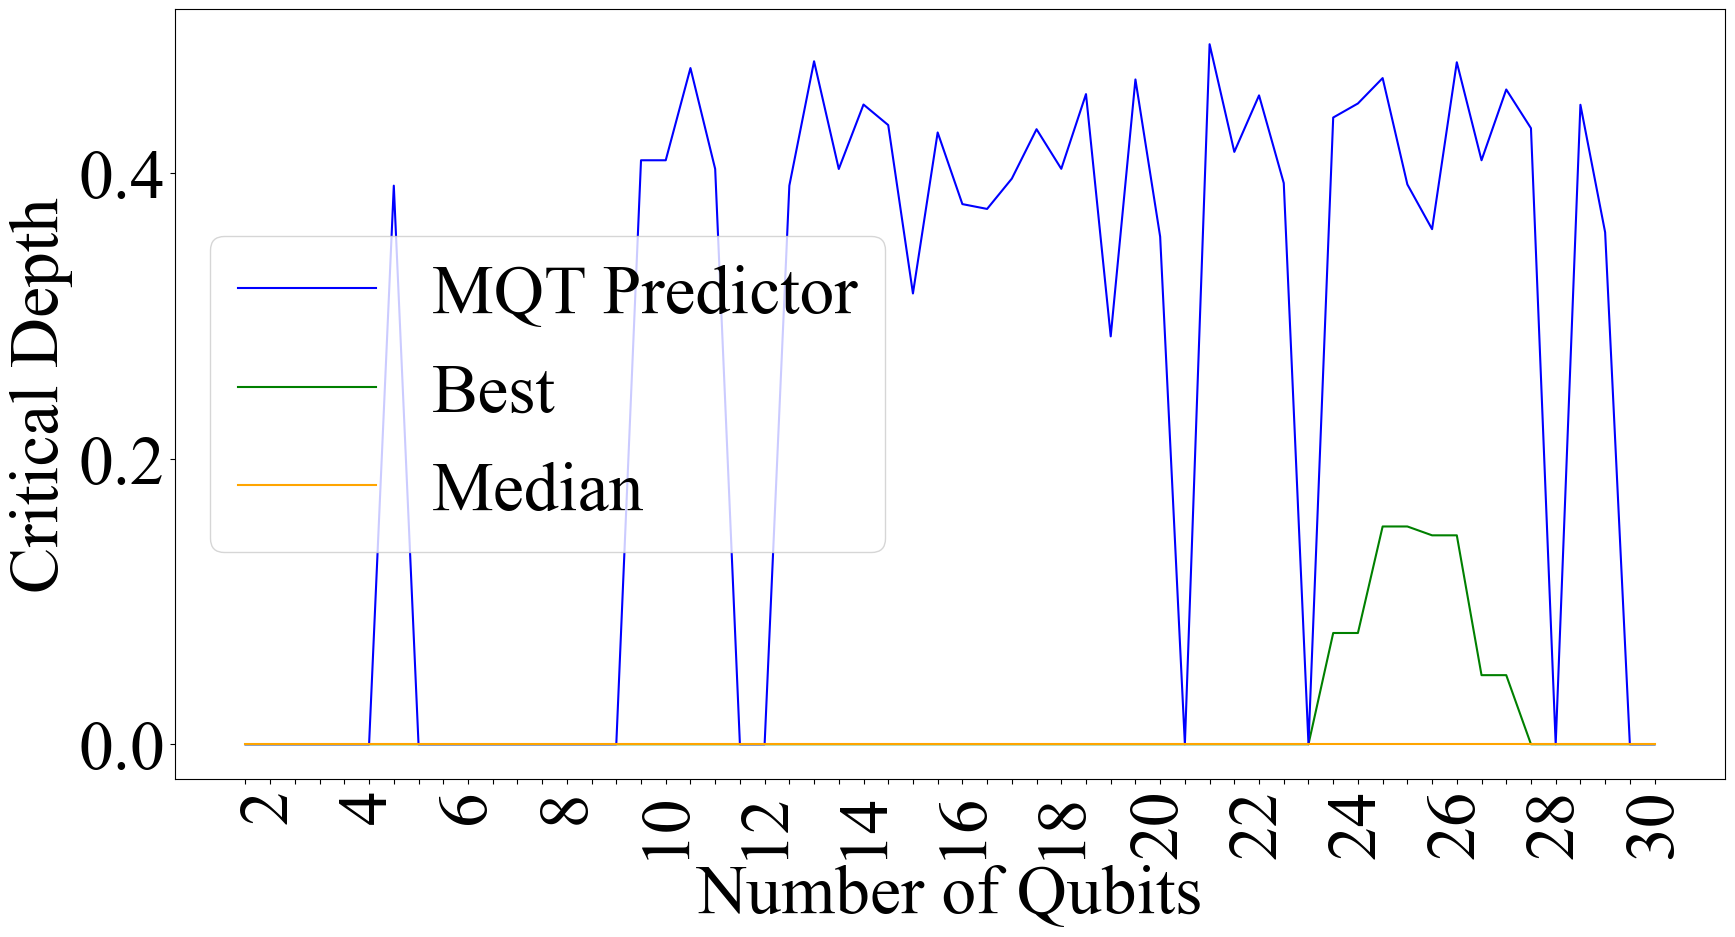

In [27]:
plot_kind = "line"
df = df.sort_values(by=['num_qubits'])
ax = df.plot(x="file_path", y="critical_depth_max_other", label="Best", rot=90, kind=plot_kind, color="green", figsize=(20,10))
df.plot(x="file_path", y="MQTPredictor_critical_depth_critical_depth", kind=plot_kind, rot=90, ax=ax, color="blue", label="MQT Predictor")
df.plot(x="file_path", y="critical_depth_median", kind=plot_kind, rot=90, ax=ax, color="orange", label="Median")

if plot_kind == "line":
    plt.xticks(range(len(df.file_path)), df.file_path);

plt.xticks(
    list(range(0, len(df), 1)),
    [df.iloc[i].num_qubits if i % 4 == 1 else "" for i in range(len(df))],
)

plt.xlabel("Number of Qubits")
plt.ylabel("Critical Depth")

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

plt.savefig("results/critical_depth_ghz_plot.pdf", bbox_inches='tight')

# Evaluation Journal Revision

In [35]:
df = pd.read_csv(ml.helper.get_path_results(), sep=',')
plt.rcParams["font.size"] = 12
plt.rcParams["lines.markersize"] = 3

device = "ibm_washington"
device_index = rl.helper.get_device_index_of_device(device)

## Data Preparation Expected Fidelity

In [29]:
training_data_expected_fidelity = predictor.get_prepared_training_data(figure_of_merit="expected_fidelity", save_non_zero_indices=True)
indices_test_expected_fidelity = training_data_expected_fidelity.indices_test
names_list_expected_fidelity = training_data_expected_fidelity.names_list
names_test_expected_fidelity = [names_list_expected_fidelity[index_test] for index_test in indices_test_expected_fidelity]
scores_test_expected_fidelity = [training_data_expected_fidelity.scores_list[index_test] for index_test in indices_test_expected_fidelity]
df_expected_fidelity = df[df["file_path"].isin(names_test_expected_fidelity)]
df_expected_fidelity["RL_" + device + "_expected_fidelity"] = df_expected_fidelity.apply(
    lambda row: max(
        scores_test_expected_fidelity[
            names_test_expected_fidelity.index(row["file_path"])
        ][device_index], 
        0), 
    axis=1)

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/1970299773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expected_fidelity["RL_" + device + "_expected_fidelity"] = df_expected_fidelity.apply(


## Data Preparation Critical Depth

In [30]:
training_data_critical_depth = predictor.get_prepared_training_data(figure_of_merit="critical_depth", save_non_zero_indices=True)
indices_test_critical_depth = training_data_critical_depth.indices_test
names_list_critical_depth = training_data_critical_depth.names_list
names_test_critical_depth = [names_list_critical_depth[index_test] for index_test in indices_test_critical_depth]
scores_test_critical_depth = [training_data_critical_depth.scores_list[index_test] for index_test in indices_test_critical_depth]
df_critical_depth = df[df["file_path"].isin(names_test_critical_depth)]
df_critical_depth["RL_" + device + "_critical_depth"] = df_critical_depth.apply(
    lambda row: max(
        scores_test_critical_depth[
            names_test_critical_depth.index(row["file_path"])]
        [device_index], 
        0), 
    axis=1)

/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/1244687463.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_critical_depth["RL_" + device + "_critical_depth"] = df_critical_depth.apply(


/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/2845083.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["num_qubits_interval", f"predicted_device_{fom}"]).size().unstack().fillna(0).plot(kind='bar', stacked=True, color=["#fde725", "#90d743", "#35b779", "#21918c", "#31688e", "#443983", "#440154"])
/var/folders/f4/n3_mnvbd6q50h0gtzy84vyn40000gn/T/ipykernel_35820/2845083.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["num_qubits_interval", f"predicted_device_{fom}"]).size().unstack().fillna(0).plot(kind='bar', stacked=True, color=["#fde725", "#90d743", "#35b779

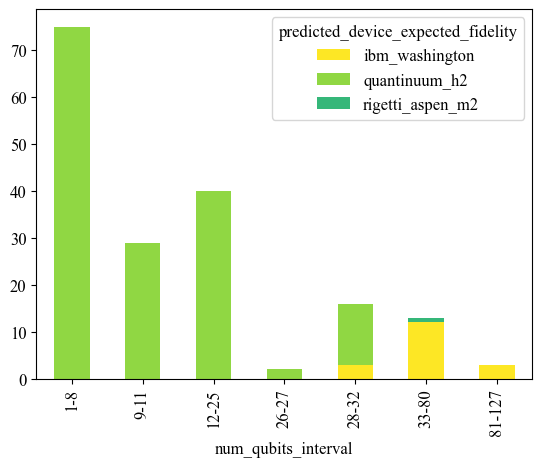

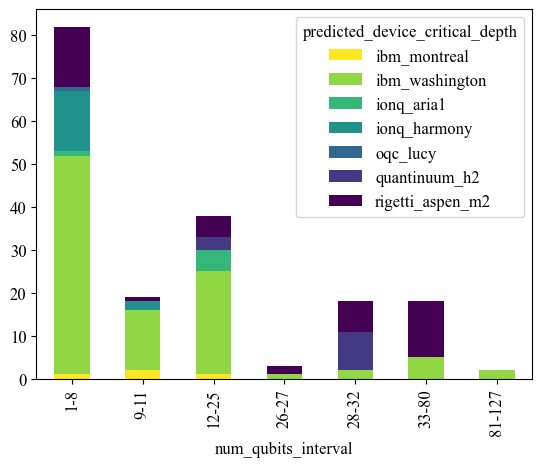

In [31]:
from qiskit import QuantumCircuit
qasm_path = ml.helper.get_path_training_circuits()

for fom in ["expected_fidelity", "critical_depth"]:
    if fom == "expected_fidelity":
        df = df_expected_fidelity
    else:
        df = df_critical_depth
    df[f"predicted_device_{fom}"] = df.apply(
    lambda row: ml.helper.predict_device_for_figure_of_merit(
        QuantumCircuit.from_qasm_file(
            qasm_path/(row["file_path"]+".qasm")), 
        figure_of_merit=fom), 
    axis=1)
    df["num_qubits_interval"] = pd.cut(df["num_qubits"], [0, 8, 11, 25, 27, 32, 80, 127], labels=["1-8", "9-11", "12-25", "26-27","28-32", "33-80", "81-127"])
    df.groupby(["num_qubits_interval", f"predicted_device_{fom}"]).size().unstack().fillna(0).plot(kind='bar', stacked=True, color=["#fde725", "#90d743", "#35b779", "#21918c", "#31688e", "#443983", "#440154"])

# Eval ML

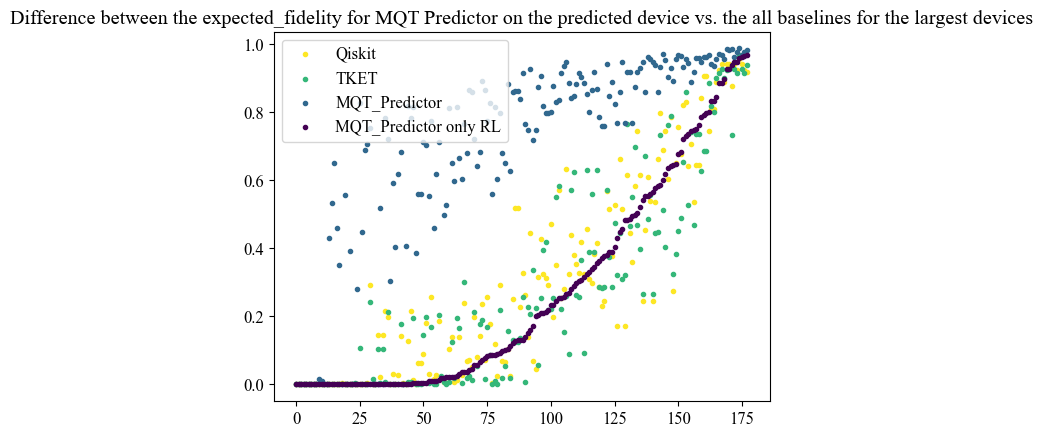

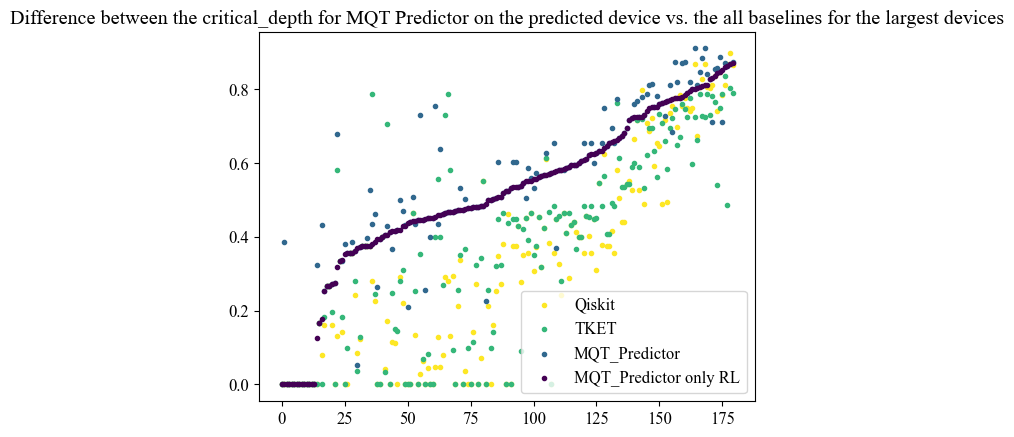

In [39]:
for fom in ["expected_fidelity", "critical_depth"]:
    if fom == "expected_fidelity":
        df = df_expected_fidelity
    else:
        df = df_critical_depth
    
    df = df.sort_values(by=[f'MQTPredictor_{fom}_{fom}'])
    df = df.sort_values(by=[f"RL_" + device + f"_{fom}"])
    
    plt.scatter(range(len(df)), df["qiskit_" + device + f"_{fom}"], label="Qiskit", color="#fde725")
    plt.scatter(range(len(df)), df["tket_" + device + f"_{fom}"], label="TKET", color="#35b779")
    plt.scatter(range(len(df)), df[f'MQTPredictor_{fom}_{fom}'], label="MQT_Predictor", color="#31688e")
    plt.scatter(range(len(df)), df["RL_" + device + f"_{fom}"], label="MQT_Predictor only RL", color="#440154")
    
    plt.title(f"Difference between the {fom} for MQT Predictor on the predicted device vs. the all baselines for the largest devices")
    plt.legend()
    plt.show()


## Eval RL

/Users/nils/Desktop/mqt-predictor/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


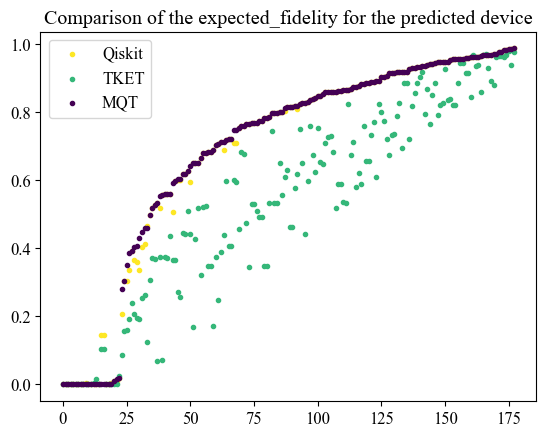

/Users/nils/Desktop/mqt-predictor/venv/lib/python3.9/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


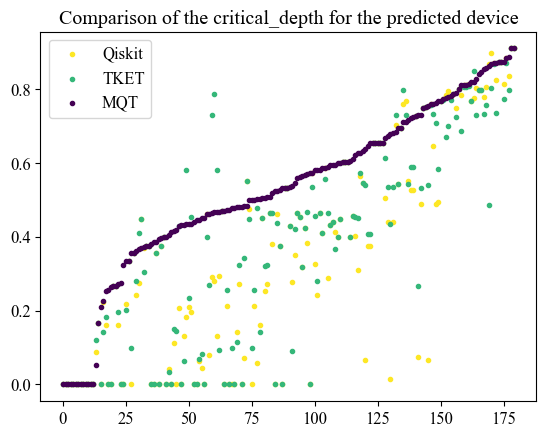

In [40]:

for fom in ["expected_fidelity", "critical_depth"]:
    if fom == "expected_fidelity":
        df = df_expected_fidelity
    else:
        df = df_critical_depth  
    df = df.sort_values(by=[f'MQTPredictor_{fom}_{fom}'])

    MQT = []
    qiskit = []
    tket = []

    
    for i, row in enumerate(df.iterrows()):
        MQT.append(row[1][[f'MQTPredictor_{fom}_{fom}']])
        qiskit.append(row[1]["qiskit_" + row[1][f"predicted_device_{fom}"] + f"_{fom}"])
        tket.append(row[1]["tket_" + row[1][f"predicted_device_{fom}"] + f"_{fom}"])
    plt.scatter(range(len(df)), qiskit, label="Qiskit", color="#fde725")
    plt.scatter(range(len(df)), tket, label="TKET", color="#35b779")
    plt.scatter(range(len(df)), MQT, label="MQT", color="#440154")
    plt.title(f"Comparison of the {fom} for the predicted device")
    plt.legend()
    plt.show()
